# How To: Land-Use-Land-Cover Prediction for Slovenia

This notebook shows the steps towards constructing a machine learning pipeline for predicting the land use and land cover for the region of Republic of Slovenia. We will use satellite images obtained by ESA's Sentinel-2 to train a model and use it for prediction. The example will lead you through the whole process of creating the pipeline, with details provided at each step.

## Before you start

### Requirements

In order to run the example you'll need a Sentinel Hub account. If you do not have one yet, you can create a free trial account at [Sentinel Hub webpage](https://services.sentinel-hub.com/oauth/subscription). If you are a researcher you can even apply for a free non-commercial account at [ESA OSEO page](https://earth.esa.int/aos/OSEO).

Once you have the account set up, login to [Sentinel Hub Configurator](https://apps.sentinel-hub.com/configurator/). By default you will already have the default configuration with an **instance ID** (alpha-numeric code of length 36). For this tutorial we recommend that you create a new configuration (`"Add new configuration"`) and set the configuration to be based on **Python scripts template**. Such configuration will already contain all layers used in these examples. Otherwise you will have to define the layers for your configuration yourself.

After you have prepared a configuration please put configuration's **instance ID** into `sentinelhub` package's configuration file following the [configuration instructions](http://sentinelhub-py.readthedocs.io/en/latest/configure.html).

### Overview

#### Part 1:

1. Define the Area-of-Interest (AOI):
   * Obtain the outline of Slovenia (provided)
   * Split into manageable smaller tiles
   * Select a small 3x3 area for classification
2. Use the integrated [sentinelhub-py](https://github.com/sentinel-hub/sentinelhub-py) package in order to fill the EOPatches with some content (band data, cloud masks, ...)
   * Define the time interval (this example uses the whole year of 2017)
3. Add additional information from band combinations (norm. vegetation index - NDVI, norm. water index - NDWI)
4. Add a reference map (provided)
   * Convert provided vector data to raster and add it to EOPatches
   
#### Part 2:

5. Prepare the training data
   * Remove too cloudy scenes
   * Perform temporal interpolation (filling gaps and resampling to the same dates)
   * Apply erosion 
   * Random spatial sampling of the EOPatches
   * Split patches for training/validation
6. Construct and train the ML model
   * Make the prediction for each patch 
7. Validate the model
8. Visualise the results

Let's start!

D:\Programs\Anaconda3\envs\venv\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Dimension of the area is 249870 x 171656 m2


(357737.03586605104, 632593.8219180192, 5016135.9977509845, 5204957.80695405)

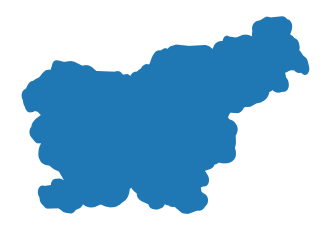

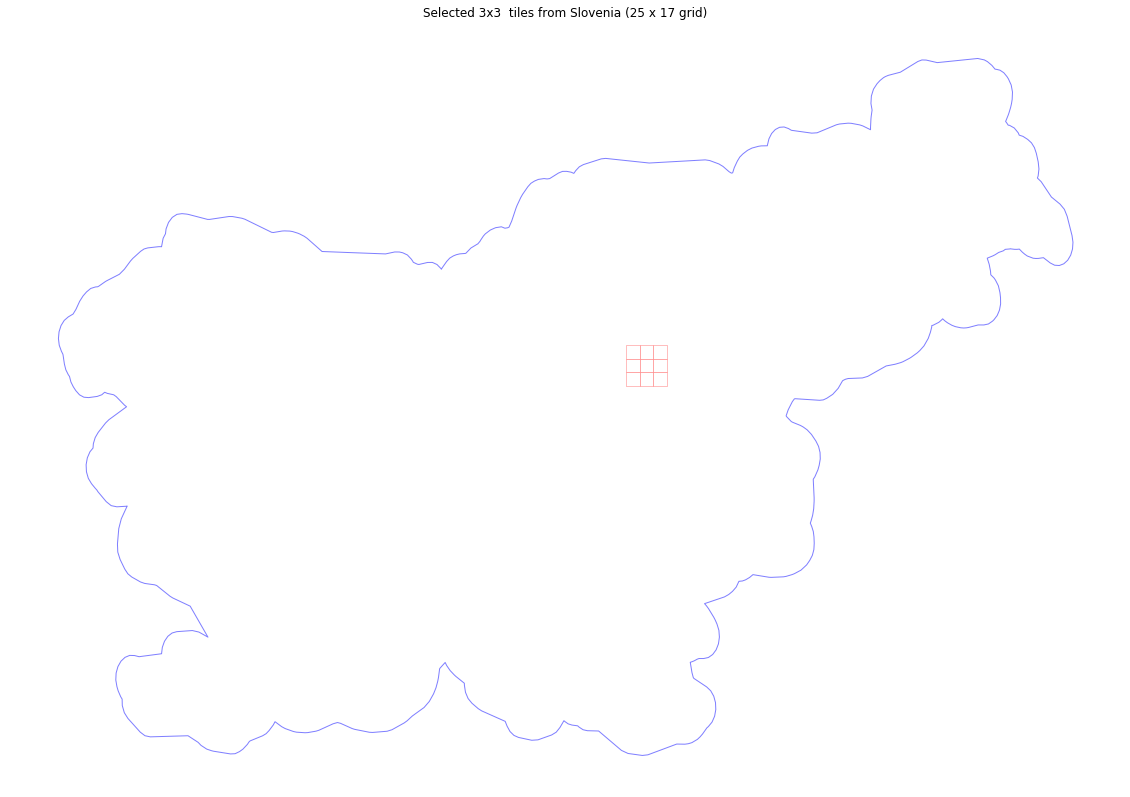

In [1]:
# Firstly, some necessary imports

# Jupyter notebook related
from collections import OrderedDict
from eolearn.core.utilities import FeatureParser
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Basics of Python data handling and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from shapely.geometry import Polygon

# Basics of GIS
import geopandas as gpd

# The core of this example
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, LoadFromDisk, SaveToDisk, EOExecutor, utilities
from eolearn.io import S2L1CWCSInput, ExportToTiff
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation,FeatureExtractionTask, SimpleFilterTask, AddSpatioTemporalFeaturesTask, AddMaxMinTemporalIndicesTask, AddMaxMinNDVISlopeIndicesTask
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam

# Machine learning 
import lightgbm as lgb
from sklearn.externals import joblib
from sklearn import metrics
from sklearn import preprocessing


# Misc
import pickle
import sys
import os
import datetime
import itertools
from tqdm import tqdm_notebook as tqdm
import enum

# Suppress warnings
sys.stderr = open(os.devnull, "w")

import os
os.getcwd()
os.chdir("C:\\Users\\benos\\OneDrive\\Documents\\IJS\\Perceptive-Sentinel\\eo-learn\\examples\\land-cover-map")
os.getcwd()


import cv2
from skimage import data, color, io, img_as_float
from PIL import Image, ImageDraw
from matplotlib import cm
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

# Load geojson file
country = gpd.read_file('../../example_data/svn_buffered.geojson')

# Convert CRS to UTM_33N
country_crs = CRS.UTM_33N
country = country.to_crs(crs={'init': CRS.ogc_string(country_crs)})

# Get the country's shape in polygon format
country_shape = country.geometry.values.tolist()[-1]

# Plot country
country.plot()
plt.axis('off');

# Print size 
print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(country_shape.bounds[2] - country_shape.bounds[0],
                                                             country_shape.bounds[3] - country_shape.bounds[1]))

use_smaller_patches = True

# Create the splitter to obtain a list of bboxes
bbox_splitter_large = BBoxSplitter([country_shape], country_crs, (25, 17))
bbox_splitter_small = BBoxSplitter([country_shape], country_crs, (25 * 3, 17 * 3))

bbox_splitter = bbox_splitter_small if use_smaller_patches else bbox_splitter_large

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# For the future examples, we will be using a specific set of patches,
# but you are free to change the patch ID numbers in the scope of this example
# Select a central patch
ID = 1549 if use_smaller_patches else 190 

# Obtain surrounding patches
patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    if (abs(info['index_x'] - info_list[ID]['index_x']) <= 1 and
        abs(info['index_y'] - info_list[ID]['index_y']) <= 1):
        patchIDs.append(idx)

# Check if final size is 3x3
if len(patchIDs) != 9:
    print('Warning! Use a different central patch ID, this one is on the border.')
    
# Change the order of the patches (used for plotting later)
patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(3, 3))).ravel()
    
# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list[patchIDs]]
idxs_x = [info['index_x'] for info in info_list[patchIDs]]
idxs_y = [info['index_y'] for info in info_list[patchIDs]]
df = pd.DataFrame({'index_x': idxs_x, 'index_y': idxs_y})
gdf = gpd.GeoDataFrame(df, 
                       crs={'init': CRS.ogc_string(country_crs)}, 
                       geometry=geometry)

# save to shapefile
shapefile_name = './selected_3x3_bboxes_slovenia_small.shp' if use_smaller_patches \
    else './selected_3x3_bboxes_slovenia_large.shp'
gdf.to_file(shapefile_name)

poly = gdf['geometry'][0]
x1, y1, x2, y2 = poly.bounds
aspect_ratio = (y1 - y2) / (x1 - x2)

# content of the geopandas dataframe
gdf.head()
fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 11}

# if bboxes have all same size, estimate offset
xl, yl, xu, yu = gdf.geometry[0].bounds
xoff, yoff = (xu - xl) / 3, (yu - yl) / 5

# figure
fig, ax = plt.subplots(figsize=(20, 20))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
country.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('Selected 3x3  tiles from Slovenia (25 x 17 grid)');
plt.axis('off')

## 2. - 4. Fill EOPatches with data:

Now it's time to create EOPatches and fill them with Sentinel-2 data using Sentinel Hub services. We will add the following data to each EOPatch:

* L1C custom list of bands [B02, B03, B04, B08, B11, B12], which corresponds to [B, G, R, NIR, SWIR1, SWIR2] wavelengths.

* SentinelHub's cloud probability map and cloud mask

Additionally, we will add:

* Calculated NDVI, NDWI, euclidean NORM information

* A mask of validity, based on acquired data from Sentinel and cloud coverage. Valid pixel is if:
   
    1. IS_DATA == True
    2. CLOUD_MASK == 0 (1 indicates that pixel was identified to be covered with cloud)

An EOPatch is created and manipulated using EOTasks, which are chained in an EOWorkflow. In this example the final workflow is executed on all patches, which are saved to the specified directory.

### Define some needed custom EOTasks

In [2]:
class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is assumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):        
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool), 
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))
    
class CountValid(EOTask):   
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name
        
    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))
        #eopatch.add_feature(FeatureType.MASK, 'VALID_DATA', eopatch[FeatureType.Mask]['IS_VALID'])
        
        return eopatch


class NormalizedDifferenceIndex(EOTask):   
    """
    The tasks calculates user defined Normalised Difference Index (NDI) between two bands A and B as:
    NDI = (A-B)/(A+B).
    """
    def __init__(self, feature_name, band_a, band_b):
        self.feature_name = feature_name
        self.band_a_fetaure_name = band_a.split('/')[0]
        self.band_b_fetaure_name = band_b.split('/')[0]
        self.band_a_fetaure_idx = int(band_a.split('/')[-1])
        self.band_b_fetaure_idx = int(band_b.split('/')[-1])
        
    def execute(self, eopatch):
        print(eopatch)
        #valid_data_mask = eopatch.mask['VALID_DATA']
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]
        
        ndi = (band_a - band_b) / (band_a  + band_b)
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, ndi[..., np.newaxis])
        
        return eopatch

    
class EuclideanNorm(EOTask):   
    """
    The tasks calculates Euclidian Norm of all bands within an array:
    norm = sqrt(sum_i Bi**2),
    where Bi are the individual bands within user-specified feature array.
    """
    def __init__(self, feature_name, in_feature_name):
        self.feature_name = feature_name
        self.in_feature_name = in_feature_name
    
    def execute(self, eopatch):
        arr = eopatch.data[self.in_feature_name]
        norm = np.sqrt(np.sum(arr**2, axis=-1))
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, norm[..., np.newaxis])
        return eopatch
    
class ValidDataFractionPredicate:
    """
    Predicate that defines if a frame from EOPatch's time-series is valid or not. Frame is valid, if the 
    valid data fraction is above the specified threshold.
    """
    def __init__(self, threshold):
        self.threshold = threshold
        
    def __call__(self, array):
        coverage = np.sum(array.astype(np.uint8)) / np.prod(array.shape)
        return coverage > self.threshold
    
class printPatch(EOTask):
    
    def __init__(self, comment='PrintPatch: \n'):
        self.comment = comment
        
    def execute(self, eopatch):
        print(self.comment)
        print(eopatch)
        return eopatch
    

    

        
        

### Define the workflow tasks

In [ ]:
# TASK FOR BAND DATA
# add a request for B(B02), G(B03), R(B04), NIR (B08), SWIR1(B11), SWIR2(B12) 
# from default layer 'ALL_BANDS' at 10m resolution
# Here we also do a simple filter of cloudy scenes. A detailed cloud cover 
# detection is performed in the next step
custom_script = 'return [B02, B03, B04, B08, B11, B12];'
add_data = S2L1CWCSInput(
    layer='BANDS-S2-L1C', 
    feature=(FeatureType.DATA, 'BANDS'), # save under name 'BANDS'
    custom_url_params={CustomUrlParam.EVALSCRIPT: custom_script}, # custom url for 6 specific bands
    resx='10m', # resolution x
    resy='10m', # resolution y
    maxcc=0.8, # maximum allowed cloud cover of original ESA tiles
)

# TASK FOR CLOUD INFO
# cloud detection is performed at 80m resolution 
# and the resulting cloud probability map and mask 
# are scaled to EOPatch's resolution
cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=False)
add_clm = AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='80m', cm_size_x='80m', 
                           cmask_feature='CLM', # cloud mask name
                           cprobs_feature='CLP' # cloud prob. map name
                          )

# TASKS FOR CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NORM: sqrt(B02^2 + B03^2 + B04^2 + B08^2 + B11^2 + B12^2)
ndvi = NormalizedDifferenceIndex('NDVI', 'BANDS/3', 'BANDS/2')
ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/1', 'BANDS/3')
norm = EuclideanNorm('NORM','BANDS')

# TASK FOR VALID MASK
# validate pixels using SentinelHub's cloud detection mask and region of acquisition 
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(), 
                                      'IS_VALID' # name of output mask
                                     )

add_sh_valmask2 = AddValidDataMaskTask(SentinelHubValidData(), 
                                      'VALID_DATA' # name of output mask
                                     )

# TASK FOR COUNTING VALID PIXELS
# count number of valid observations per pixel using valid data mask 
count_val_sh = CountValid('IS_VALID', # name of existing mask
                          'VALID_COUNT' # name of output scalar
                         )



'''
base_bands_feature,
                ndvi_feature,
                feature_name,
                feature_type,
                dilation_mask,
                closing_mask,
                low_treshold,
                high_treshold,
                ndvi_treshold,
                mean_
'''
# TASK FOR SAVING TO OUTPUT (if needed)
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'
if not os.path.isdir(path_out):
    os.makedirs(path_out)
save = SaveToDisk(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [ ]:
class LULC(enum.Enum):
    NO_DATA            = (0,  'No Data',            'white')
    CULTIVATED_LAND    = (1,  'Cultivated Land',    'xkcd:lime')
    FOREST             = (2,  'Forest',             'xkcd:darkgreen')
    GRASSLAND          = (3,  'Grassland',          'orange')
    SHRUBLAND          = (4,  'Shrubland',          'xkcd:tan')
    WATER              = (5,  'Water',              'xkcd:azure')
    WETLAND            = (6,  'Wetlands',           'xkcd:lightblue')
    TUNDRA             = (7,  'Tundra',             'xkcd:lavender')
    ARTIFICIAL_SURFACE = (8,  'Artificial Surface', 'crimson')
    BARELAND           = (9,  'Bareland',           'xkcd:beige')
    SNOW_AND_ICE       = (10, 'Snow and Ice',       'black')
    
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3   
        
# example usecase
# LULC.BARELAND.id   # return 9
        
# Reference colormap things
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
lulc_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, 11, 1), lulc_cmap.N)

The main point of this task is to create a raster mask from the vector polygons and add it to the eopatch. With this procedure, any kind of a labeled shapefile can be transformed into a raster reference map. This result is achieved with the existing task `VectorToRaster` from the `eolearn.geometry` package. All polygons belonging to the each of the classes are separately burned to the raster mask.

Land use data are public in Slovenia, you can download the full dataset [here](http://rkg.gov.si/GERK/), selecting the `Grafični podatki RABA za celo Slovenijo (shape.rar ~ 500 MB) KoordSistem: D96/TM`. The dataset is provided in the national `D96/TM` coordinate system. In order to use this dataset, you have to first convert the CRS to `UTM_33N`!

The provided dataset in this notebook has already been converted for the purposes of the example.

In [ ]:
land_cover_path = '../../example_data/land_cover_subset_small/land_cover_subset_small.shp' if use_smaller_patches \
    else '../../example_data/land_cover_subset_large/land_cover_subset_large.shp'

land_cover = gpd.read_file(land_cover_path)

land_cover_val = [0,1,2,3,4,5,6,7,8,9,10]
land_cover_array = []
for val in land_cover_val:
    temp = land_cover[land_cover.lulcid == val]
    temp.reset_index(drop=True, inplace=True)
    land_cover_array.append(temp)
    del temp
    
rshape = (FeatureType.MASK, 'IS_VALID')

land_cover_task_array = []
for el, val in zip(land_cover_array, land_cover_val):
    land_cover_task_array.append(VectorToRaster(
        feature=(FeatureType.MASK_TIMELESS, 'LULC'), 
        vector_data=el,
        raster_value=val, 
        raster_shape=rshape,
        raster_dtype=np.uint8))
    
# TASK FOR FILTERING OUT TOO CLOUDY SCENES
# keep frames with > 80 % valid coverage
valid_data_predicate = ValidDataFractionPredicate(0.8)
filter_task = SimpleFilterTask((FeatureType.MASK, 'IS_VALID'), valid_data_predicate)

# TASK FOR LINEAR INTERPOLATION
# linear interpolation of full time-series and date resampling
resampled_range = ('2017-01-01', '2017-12-31', 16)

bands_interpolation = LinearInterpolation(
    'BANDS', # name of field to interpolate
    mask_feature=(FeatureType.MASK, 'IS_VALID'), # mask to be used in interpolation
    resample_range=resampled_range, # set the resampling range
    bounds_error=False # extrapolate with NaN's
)


In [ ]:

# Define the workflow
workflow = LinearWorkflow(
    add_data,
    add_clm,
    add_sh_valmask,
    printPatch('after valmask'),
    count_val_sh,
    add_sh_valmask2,
    printPatch('after valmask2'),
    ndwi,
    norm,
    printPatch('after norm'),
    *land_cover_task_array,
    printPatch('after lc array'),
    bands_interpolation,
    printPatch('after interpolation'),
    #,
    ndvi,
    save
)

EXECUTION of the workflow________#############################################################


In [ ]:
%%time

# Execute the workflow
time_interval = ['2017-01-01', '2017-12-31'] # time interval for the SH request

# Show progress bar 
pbar = tqdm(total=len(patchIDs))
for idx, bbox in enumerate(bbox_list[patchIDs]):
    
    # define additional parameters of the workflow
    extra_param = {
        add_data:{'bbox': bbox, 'time_interval': time_interval},
        save: {'eopatch_folder': 'eopatch_{}'.format(idx)}
    }
    
    workflow.execute(extra_param)    
    pbar.update(1)

In this case, all patches come from a small region, so all of them have the same dates of acquisition for at least a few dates, so we can inspect the area without interpolation at this point.

In [ ]:
class Vegetation(EOTask):
    "Extracting positions of vegetation. The extracted area has well defined borders where there is another area with\
    vegetation just beside it"
    
    def __init__(self, 
                base_bands_feature,
                ndvi_feature,
                feature_vegetation,
                feature_edges,
                dilation_mask,
                closing_mask,
                low_treshold,
                high_treshold,
                ndvi_treshold,
                join_edges_treshold,
                join_vegetation_treshold,
                feature_join):
        
        self.feature_vegetation = feature_vegetation
        self.feature_edges = feature_edges
        self.dilation_mask = dilation_mask
        self.closing_mask = closing_mask
        self.low_treshold = low_treshold
        self.high_treshold = high_treshold
        self.ndvi_treshold = ndvi_treshold
        self.join_edges_treshold = join_edges_treshold
        self.join_vegetation_treshold = join_vegetation_treshold
        
        self.f = self._parse_features(base_bands_feature, new_names=False)
        self.base_feature_parsed = list(FeatureParser._parse_features(base_bands_feature, new_names=False).items())[0]
        self.base_feature = (self.base_feature_parsed[0],list(self.base_feature_parsed[1].items())[0][0])

        self.ndvi_feature_parsed = list(FeatureParser._parse_features(ndvi_feature, new_names=False).items())[0]
        self.ndvi_feature = (self.ndvi_feature_parsed[0],list(self.ndvi_feature_parsed[1].items())[0][0])
        
        self.feature_join = feature_join

        
    def execute(self, eopatch):
        ndvi = eopatch.data['NDVI']
        t, w, h, _ = ndvi.shape 
        all_segments = np.zeros((t,w,h))
        all_edges = np.zeros((t,w,h))
        sum_segments = np.zeros((w,h))
        sum_edges = np.zeros((w,h))
                
        for time in range(len(eopatch.timestamp)):
            
            img0 = np.clip(eopatch[self.base_feature[0]][self.base_feature[1]][time][..., [2, 1, 0]] * 3.5, 0, 1)
            img = rgb2gray(img0)
            img = (img*255).astype(np.uint8)
            
            #Extracting edges
            edges = cv2.Canny(img,self.low_treshold,self.high_treshold)
            
            ndvi = eopatch[self.ndvi_feature[0]][self.ndvi_feature[1]][time]
            
            #Take only areas where NDVI sufficiently high
            ndvi_tresh = ndvi > self.ndvi_treshold
            ndvi_tresh = 1-ndvi_tresh
            
            #Taking a bigger area to account for error
            ndvi_tresh = cv2.dilate((ndvi_tresh*255).astype(np.uint8), self.dilation_mask*255)
            
            #Fill in the holes between areas with low NDVI, such as parks, gardens
            ndvi_tresh = cv2.morphologyEx((ndvi_tresh*255), cv2.MORPH_CLOSE, self.closing_mask*255)
            edges = cv2.dilate((edges*255).astype(np.uint8), self.dilation_mask*255)

            without_city = ndvi_tresh
            plant_surface = 1-without_city

            all_segments[time] = plant_surface
            all_edges[time] = edges
            
            sum_segments = sum_segments + plant_surface
            sum_edges = sum_edges + edges
            
        #Joining both measurements into account
        sum_segments = sum_segments/t
        sum_edges = sum_edges/t
        sum_segments = sum_segments >self.join_vegetation_treshold
        sum_edges = sum_edges>self.join_edges_treshold
        sum_edges = 1-sum_edges
        joined = np.logical_and(sum_segments,sum_edges)

        eopatch.add_feature(self.feature_vegetation[0],self.feature_vegetation[1],all_segments[...,np.newaxis])
        eopatch.add_feature(self.feature_edges[0],self.feature_edges[1],all_edges[...,np.newaxis])
        eopatch.add_feature(self.feature_join[0],self.feature_join[1],joined[...,np.newaxis])
        
        return eopatch


In [ ]:
#TASK FOR PRACTICE
vegetation = Vegetation(
                            ndvi_feature = (FeatureType.DATA,'NDVI'),
                            base_bands_feature = (FeatureType.DATA,'BANDS'),
                            feature_vegetation = (FeatureType.MASK,'VEGETATION'),
                            feature_edges = (FeatureType.MASK,'EDGES'),
                            feature_join = (FeatureType.MASK_TIMELESS,'VEGETATION_TIMELESS'),
                            dilation_mask = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2)),
                            closing_mask = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)),
                            low_treshold = 60,
                            high_treshold = 120,
                            ndvi_treshold = 0.3,
                            join_edges_treshold = 0.2,
                            join_vegetation_treshold = 0)

path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'

load = LoadFromDisk(path_out)


path_out_veg = './eopatches_small_veg/'
if not os.path.isdir(path_out_veg):
    os.makedirs(path_out_veg)
save_veg = SaveToDisk(path_out_veg, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

#allValid = makeAllValid(FeatureType.MASK, 'VALID_DATA', 23, 337, 333, 1)

maxMinNDVI = AddMaxMinTemporalIndicesTask() 


In [ ]:
workflow = LinearWorkflow(
    load,
    #allValid,
    #printPatch(),
    maxMinNDVI,
    #printPatch()
    vegetation,
    save_veg
    #veg_segmentation
)

# Execute the workflow
time_interval = ['2017-01-01', '2017-12-31'] # time interval for the SH request

pbar = tqdm(total=len(patchIDs))
for i in range(len(patchIDs)):
    # define additional parameters of the workflow
    extra_param = {
        load: {'eopatch_folder': 'eopatch_{}'.format(i)},
        save_veg: {'eopatch_folder': 'eopatch_{}'.format(i)}
    }
    
    workflow.execute(extra_param)    
    pbar.update(1)

###########################################   VEGETATION MASK

In [ ]:
#path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'
path_out_veg = './eopatches_small_veg/' if use_smaller_patches else './eopatches_large_veg/'

fig, axes = plt.subplots(figsize=(20, 20 * aspect_ratio), nrows=3, ncols=3)
    
pbar = tqdm(total=9)
for i, ax in enumerate(axes.flat):
    #print(eopatch)
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out_veg, i), lazy_loading=True)
    #timestamps = len(eopatch[FeatureType.MASK]['NATURAL'][0][:][0][0])
    ndvi = eopatch[FeatureType.MASK]['VEGETATION']
    t, w, h, _= ndvi.shape 
    
    veg = np.zeros((w,h,1))
    for time in range(t):
        veg = veg + eopatch[FeatureType.MASK]['VEGETATION'][time]
        
    veg = veg.squeeze()
    veg = veg/t
    veg = veg!=0
    im = ax.imshow(veg,cmap=plt.get_cmap('gray'))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

#cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
#cb.ax.tick_params(labelsize=20) 
plt.show()

In [ ]:
################################################          EDGES

In [ ]:
#fig = plt.figure(figsize=(20,5))
path_out_veg = './eopatches_small_veg/' if use_smaller_patches else './eopatches_large_veg/'

fig, axes = plt.subplots(figsize=(20, 20 * aspect_ratio), nrows=3, ncols=3)
    
pbar = tqdm(total=9)
for i, ax in enumerate(axes.flat):
    #print(eopatch)
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out_veg, i), lazy_loading=True)
    #timestamps = len(eopatch[FeatureType.MASK]['NATURAL'][0][:][0][0])
    ndvi = eopatch[FeatureType.MASK]['EDGES']
    t, w, h, _= ndvi.shape 
        
    edges = np.zeros((w,h,1))
    for time in range(t):
        edges = edges + eopatch[FeatureType.MASK]['EDGES'][time]
    
    edges = edges.squeeze()
    edges = edges/t
    edges = edges>0.2
    edges = 1-edges
    im = ax.imshow(edges,cmap=plt.get_cmap('gray'))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

#cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
#cb.ax.tick_params(labelsize=20) 
plt.show()

___________________________________________________________________________________________
#################################################################### RESULTS JOIN VEGETATION-EDGES
____________________________
_____________________

In [ ]:
#fig = plt.figure(figsize=(20,5))
path_out_veg = './eopatches_small_veg/' if use_smaller_patches else './eopatches_large_veg/'

fig, axes = plt.subplots(figsize=(20, 20 * aspect_ratio), nrows=3, ncols=3)
    
pbar = tqdm(total=9)
for i, ax in enumerate(axes.flat):
    #print(eopatch)
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out_veg, i), lazy_loading=True)
    #timestamps = len(eopatch[FeatureType.MASK]['NATURAL'][0][:][0][0])
    vegetation = eopatch[FeatureType.MASK_TIMELESS]['VEGETATION_TIMELESS']
    vegetation = vegetation.squeeze()
    #w, h, _= ve.shape 

    
    im = ax.imshow(vegetation,cmap=plt.get_cmap('gray'))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

#cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
#cb.ax.tick_params(labelsize=20) 
plt.show()

In [ ]:
#fig = plt.figure(figsize=(20,5))
path_out_veg = './eopatches_small_veg/' if use_smaller_patches else './eopatches_large_veg/'

fig, axes = plt.subplots(figsize=(20, 20 * aspect_ratio), nrows=3, ncols=3)
    
pbar = tqdm(total=9)
for i, ax in enumerate(axes.flat):
    #print(eopatch)
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out_veg, i), lazy_loading=True)
    #timestamps = len(eopatch[FeatureType.MASK]['NATURAL'][0][:][0][0])
    ndvi = eopatch[FeatureType.MASK]['EDGES']
    t, w, h, _= ndvi.shape 
        
    edges = np.zeros((w,h,1))
    for time in range(t):
        edges = edges + eopatch[FeatureType.MASK]['EDGES'][time]
        
    veg = np.zeros((w,h,1))
    for time in range(t):
        veg = veg + eopatch[FeatureType.MASK]['VEGETATION'][time]
    
    edges = edges.squeeze()
    edges = edges/t
    edges = edges>0.2
    
    veg = veg.squeeze()
    veg = veg/t
    veg = veg !=0
    edges = 1-edges
    
    join = np.logical_and(veg,edges)
    
    im = ax.imshow(join,cmap=plt.get_cmap('gray'))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

#cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
#cb.ax.tick_params(labelsize=20) 
plt.show()

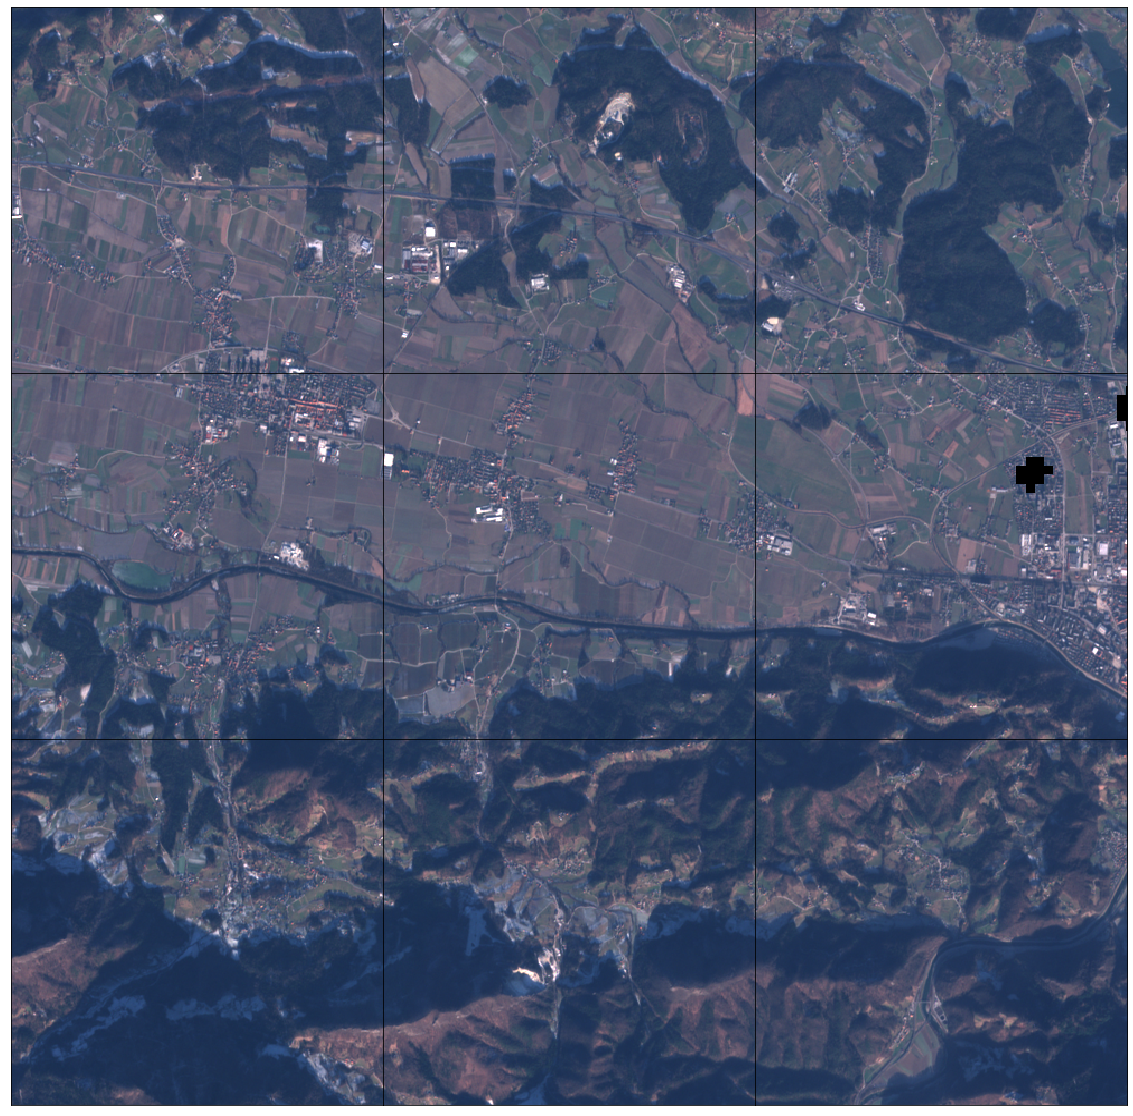

In [31]:
# Draw the RGB image
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'
fig = plt.figure(figsize=(20, 20 * aspect_ratio))

pbar = tqdm(total=9)
for i in range(9):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i), lazy_loading=True)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.clip(eopatch.data['BANDS'][0][..., [2, 1, 0]] * 3.5, 0, 1))
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)


________________________________________________________________________
################################################################################## SEGMENTATION

In [3]:
class Preprocess(EOTask):
    
    def __init__(self, feature_type,feature_name, t, h, w, l):
        self.feature_type = feature_type
        self.feature_name = feature_name
        self.t = t
        self.h = h
        self.w = w
        self.l = l
        
    def execute(self, eopatch):
        matrix = np.ones((self.t, self.h, self.w, self.l))
        eopatch.add_feature(self.feature_type, self.feature_name, matrix)
        eopatch.add_feature(FeatureType.DATA,'B4', eopatch.data['BANDS'][...,[4]])
        #print(eopatch)
        return eopatch
    
class printPatch(EOTask):
    
    def __init__(self, comment='PrintPatch: \n'):
        self.comment = comment
        
    def execute(self, eopatch):
        print(self.comment)
        print(eopatch)
        return eopatch
    



In [20]:
class NormalizeSpatioTemporalFeaturesTask(EOTask):
    #sem mislu da je v time... to ni: puts all times on a scale [0,1] where 0 - start time and 1 - end time of all times in a patch
    #da samo featurje v isti vektor
    def __init__(self, new_feature_name, features):
        self.features = features
        self.feature_name = new_feature_name
    
    def execute(self, eopatch):
        start_time = eopatch.timestamp[0] #Ne bo delalo, če imamo podatke za več let
        end_time = eopatch.timestamp[-1]
        
        total_days = (end_time-start_time).days
        
        no_features = len(self.features)
        print(eopatch)
        print(self.features[0][0])
        print(self.features[0][1])
        
        w, h, _ = eopatch[self.features[0][0]][self.features[0][1]].shape
        
        all_vectors = np.zeros((w,h,no_features))
        for i in range(w):
            for j in range(h):
                normalized_vector = []
                for feature_type,feature_name in self.features:
                    normalized_vector.append(eopatch[feature_type][feature_name][i][j][0])#To mogoče še normalizirat
                all_vectors[i][j][:]=normalized_vector
                
        eopatch.add_feature(FeatureType.MASK_TIMELESS,self.feature_name,all_vectors)
                    
            



In [15]:
class SegmentationTask(EOTask):
    
    def __init__(self,feature_mask, feature_comparison):
        self.feature_mask = feature_mask
        self.feature_comparison = feature_comparison

    '''
    def bucket_tool(image, compare_function):
        w,h=image.shape
        output = 
        
        for x in range(w)
        
        #http://cs-tklab.na-inet.jp/~tkouya/python/scipy-lectures/packages/scikit-image/index.html#image-segmentation
    '''
    
    def execute(self, eopatch):
        #https://docs.opencv.org/3.1.0/d3/dc0/group__imgproc__shape.html#gac2718a64ade63475425558aa669a943a
        input_image = eopatch[feature_mask[0]][feature_mask[1]].squeeze()
        output_image,labels,stats,centroids = cv2.connectedComponentsWithStats(input_image)
        
        
        

SyntaxError: invalid syntax (<ipython-input-15-f9da5f6ca979>, line 9)

In [21]:
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'




path_out_veg = './eopatches_small_veg/' if use_smaller_patches else './eopatches_large_veg/'

load_veg = LoadFromDisk(path_out_veg)

if not os.path.isdir(path_out_veg):
    os.makedirs(path_out_veg)

path_out_seg = './eopatches_small_seg/'
save_seg = SaveToDisk(path_out_seg, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

preprocess = Preprocess(FeatureType.MASK, 'VALID_DATA', 23, 337, 333, 1)

maxMinNDVI = AddMaxMinTemporalIndicesTask() 
addSlope = AddMaxMinNDVISlopeIndicesTask()
#TODO 
#DODAT SE B7
#temporal features
addSpatioTemporal = AddSpatioTemporalFeaturesTask(data_feature = 'BANDS', indices=[0,1,4])#DODAT SE B7
addB4 = AddMaxMinTemporalIndicesTask(data_feature = 'B4', amax_data_feature = 'ARGMAX_B4', amin_data_feature = 'ARGMIN_B4')

nstf = NormalizeSpatioTemporalFeaturesTask(new_feature_name='NSTF',
                                                    features=[  (FeatureType.DATA_TIMELESS,'ARGMAX_B4'),
                                                                (FeatureType.DATA_TIMELESS,'ARGMAX_NDVI'),
                                                                (FeatureType.DATA_TIMELESS,'ARGMAX_NDVI_SLOPE'),
                                                                (FeatureType.DATA_TIMELESS,'ARGMIN_B4'),
                                                                (FeatureType.DATA_TIMELESS,'ARGMIN_NDVI'),
                                                                (FeatureType.DATA_TIMELESS,'ARGMIN_NDVI_SLOPE')]
                                                    )

In [22]:
workflow = LinearWorkflow(
    load_veg,
    #printPatch(),
    preprocess,
    #printPatch()
    maxMinNDVI,
    addSlope,
    printPatch(),
    addB4,
    printPatch('before temporal'),
    addSpatioTemporal,
    nstf,
    printPatch()
    #segmentation,
    #save_seg     
)


# Execute the workflow
time_interval = ['2017-01-01', '2017-12-31'] # time interval for the SH request

pbar = tqdm(total=len(patchIDs))
for i in range(len(patchIDs)):
    # define additional parameters of the workflow
    extra_param = {
        load_veg: {'eopatch_folder': 'eopatch_{}'.format(i)},
        save_seg: {'eopatch_folder': 'eopatch_{}'.format(i)}
    }
    
    workflow.execute(extra_param)    
    pbar.update(1)


PrintPatch: 

EOPatch(
  data: {
    B4: numpy.ndarray(shape=(23, 337, 333, 1), dtype=float64)
    BANDS: numpy.ndarray(shape=(23, 337, 333, 6), dtype=float64)
    NDVI: numpy.ndarray(shape=(23, 337, 333, 1), dtype=float64)
  }
  mask: {
    EDGES: numpy.ndarray(shape=(23, 337, 333, 1), dtype=float64)
    VALID_DATA: numpy.ndarray(shape=(23, 337, 333, 1), dtype=float64)
    VEGETATION: numpy.ndarray(shape=(23, 337, 333, 1), dtype=float64)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    ARGMAX_NDVI: numpy.ndarray(shape=(337, 333, 1), dtype=int64)
    ARGMAX_NDVI_SLOPE: numpy.ndarray(shape=(337, 333, 1), dtype=uint8)
    ARGMIN_NDVI: numpy.ndarray(shape=(337, 333, 1), dtype=int64)
    ARGMIN_NDVI_SLOPE: numpy.ndarray(shape=(337, 333, 1), dtype=uint8)
  }
  mask_timeless: {
    VEGETATION_TIMELESS: numpy.ndarray(shape=(337, 333, 1), dtype=bool)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((510157.61722214246, 5122327.2

)
before temporal
EOPatch(
  data: {
    B4: numpy.ndarray(shape=(23, 337, 333, 1), dtype=float64)
    BANDS: numpy.ndarray(shape=(23, 337, 333, 6), dtype=float64)
    NDVI: numpy.ndarray(shape=(23, 337, 333, 1), dtype=float64)
  }
  mask: {
    EDGES: numpy.ndarray(shape=(23, 337, 333, 1), dtype=float64)
    VALID_DATA: numpy.ndarray(shape=(23, 337, 333, 1), dtype=float64)
    VEGETATION: numpy.ndarray(shape=(23, 337, 333, 1), dtype=float64)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    ARGMAX_B4: numpy.ndarray(shape=(337, 333, 1), dtype=int64)
    ARGMAX_NDVI: numpy.ndarray(shape=(337, 333, 1), dtype=int64)
    ARGMAX_NDVI_SLOPE: numpy.ndarray(shape=(337, 333, 1), dtype=uint8)
    ARGMIN_B4: numpy.ndarray(shape=(337, 333, 1), dtype=int64)
    ARGMIN_NDVI: numpy.ndarray(shape=(337, 333, 1), dtype=int64)
    ARGMIN_NDVI_SLOPE: numpy.ndarray(shape=(337, 333, 1), dtype=uint8)
  }
  mask_timeless: {
    VEGETATION_TIMELESS: numpy.ndarray(shape=(337, 333, 1), dtype=bool)

)
EOPatch(
  data: {
    B4: numpy.ndarray(shape=(23, 337, 333, 1), dtype=float64)
    BANDS: numpy.ndarray(shape=(23, 337, 333, 6), dtype=float64)
    NDVI: numpy.ndarray(shape=(23, 337, 333, 1), dtype=float64)
  }
  mask: {
    EDGES: numpy.ndarray(shape=(23, 337, 333, 1), dtype=float64)
    VALID_DATA: numpy.ndarray(shape=(23, 337, 333, 1), dtype=float64)
    VEGETATION: numpy.ndarray(shape=(23, 337, 333, 1), dtype=float64)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    ARGMAX_B4: numpy.ndarray(shape=(337, 333, 1), dtype=int64)
    ARGMAX_NDVI: numpy.ndarray(shape=(337, 333, 1), dtype=int64)
    ARGMAX_NDVI_SLOPE: numpy.ndarray(shape=(337, 333, 1), dtype=uint8)
    ARGMIN_B4: numpy.ndarray(shape=(337, 333, 1), dtype=int64)
    ARGMIN_NDVI: numpy.ndarray(shape=(337, 333, 1), dtype=int64)
    ARGMIN_NDVI_SLOPE: numpy.ndarray(shape=(337, 333, 1), dtype=uint8)
    STF: numpy.ndarray(shape=(337, 333, 15), dtype=float64)
  }
  mask_timeless: {
    VEGETATION_TIMELESS: nu

)
FeatureType.DATA_TIMELESS
ARGMAX_B4
PrintPatch: 

None
PrintPatch: 

EOPatch(
  data: {
    B4: numpy.ndarray(shape=(23, 337, 333, 1), dtype=float64)
    BANDS: numpy.ndarray(shape=(23, 337, 333, 6), dtype=float64)
    NDVI: numpy.ndarray(shape=(23, 337, 333, 1), dtype=float64)
  }
  mask: {
    EDGES: numpy.ndarray(shape=(23, 337, 333, 1), dtype=float64)
    VALID_DATA: numpy.ndarray(shape=(23, 337, 333, 1), dtype=float64)
    VEGETATION: numpy.ndarray(shape=(23, 337, 333, 1), dtype=float64)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    ARGMAX_NDVI: numpy.ndarray(shape=(337, 333, 1), dtype=int64)
    ARGMAX_NDVI_SLOPE: numpy.ndarray(shape=(337, 333, 1), dtype=uint8)
    ARGMIN_NDVI: numpy.ndarray(shape=(337, 333, 1), dtype=int64)
    ARGMIN_NDVI_SLOPE: numpy.ndarray(shape=(337, 333, 1), dtype=uint8)
  }
  mask_timeless: {
    VEGETATION_TIMELESS: numpy.ndarray(shape=(337, 333, 1), dtype=bool)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  m